In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/University/machine_learning/old_ml/exercise

Mounted at /content/gdrive
/content/gdrive/MyDrive/University/machine_learning/old_ml/exercise


In [3]:
!ls

0_ml_exercise_preprocess.ipynb	1_ml_exercise_classical.ipynb  2_ml_exercise_neural.ipynb  data


In [4]:
%%capture
!pip install shap

In [5]:
#imports for data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#imports for data set balancing
from imblearn.over_sampling import SMOTE

#imports for model training and evaluation
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

#import for feature importance
import shap

np.random.seed(42)
tf.random.set_seed(42)

In [6]:
depress_kbest = pd.read_csv("data/depress_kbest.csv")
depress_kbest.head()

,DEPRI,INFER,ANXI,POSSAT,CHEAT,ABUSED,CONFLICT,SUICIDE,THREAT,LOST,FINSTR,INSOM,ENVSAT,DEBT,DEPRESSED
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [7]:
depress_rfe = pd.read_csv("data/depress_rfe.csv")
depress_rfe.head()

,DEPRI,INFER,ANXI,POSSAT,CHEAT,CONFLICT,LOST,FINSTR,ENVSAT,EDU,WRKPRE,TSSN,AVGSLP,PHYEX,DEPRESSED
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,1.0
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,2.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0


In [8]:
X_kbest = depress_kbest.drop("DEPRESSED", axis=1)
y_kbest = depress_kbest["DEPRESSED"]

X_rfe = depress_rfe.drop("DEPRESSED", axis=1)
y_rfe = depress_rfe["DEPRESSED"]

##1 Select K Best data set

###1.1 Data set balancing

In [9]:
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(X_kbest, y_kbest, test_size=0.2,
                                                                            random_state=42, stratify=y_kbest)

X_train_kbest.shape, X_test_kbest.shape, y_train_kbest.shape, y_test_kbest.shape

((483, 14), (121, 14), (483,), (121,))

In [10]:
sm = SMOTE(random_state=42)
X_train_kbest_res, y_train_kbest_res = sm.fit_resample(X_train_kbest, y_train_kbest)

In [11]:
np.bincount(y_train_kbest_res)

array([317, 317])

In [12]:
X_train_kbest_res.shape, y_train_kbest_res.shape

((634, 14), (634,))

###1.2 Training

In [13]:
scaler = MinMaxScaler()

X_train_kbest_res = scaler.fit_transform(X_train_kbest_res)
X_test_kbest = scaler.transform(X_test_kbest)

In [14]:
y_train_kbest_res = y_train_kbest_res.to_numpy()
y_test_kbest = y_test_kbest.to_numpy()

In [15]:
type(y_train_kbest_res)

numpy.ndarray

In [67]:
keras.backend.clear_session()

model_kbest = keras.models.Sequential()

early_stopping = EarlyStopping(monitor="val_loss", mode = "min", patience=10)
num_epochs = 200


model_kbest.add(keras.layers.Dense(100, activation='relu', name='hidden1'))
model_kbest.add(keras.layers.Dropout(0.5))
model_kbest.add(keras.layers.Dense(25, activation='relu', name='hidden2'))
model_kbest.add(keras.layers.Dropout(0.5))
model_kbest.add(keras.layers.Dense(1, activation='sigmoid', name='affine'))

model_kbest.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=keras.optimizers.Adam(learning_rate=0.001),
               metrics=["acc"])

history = model_kbest.fit(x=X_train_kbest_res,
                     y=y_train_kbest_res,
                     epochs=num_epochs,
                     validation_data=(X_test_kbest, y_test_kbest),
                     callbacks=[early_stopping])

model_kbest.summary()

Epoch 1/200
20/20 [==============================] - 2s 19ms/step - loss: 0.6953 - acc: 0.5095 - val_loss: 0.6291 - val_acc: 0.7273
Epoch 2/200
20/20 [==============================] - 0s 7ms/step - loss: 0.6361 - acc: 0.6278 - val_loss: 0.5623 - val_acc: 0.8678
Epoch 3/200
20/20 [==============================] - 0s 3ms/step - loss: 0.5793 - acc: 0.7603 - val_loss: 0.4730 - val_acc: 0.9008
Epoch 4/200
20/20 [==============================] - 0s 4ms/step - loss: 0.4978 - acc: 0.8155 - val_loss: 0.3809 - val_acc: 0.8926
Epoch 5/200
20/20 [==============================] - 0s 4ms/step - loss: 0.4255 - acc: 0.8265 - val_loss: 0.3077 - val_acc: 0.9174
Epoch 6/200
20/20 [==============================] - 0s 4ms/step - loss: 0.3601 - acc: 0.8628 - val_loss: 0.2946 - val_acc: 0.8760
Epoch 7/200
20/20 [==============================] - 0s 4ms/step - loss: 0.3252 - acc: 0.8659 - val_loss: 0.2622 - val_acc: 0.8926
Epoch 8/200
20/20 [==============================] - 0s 4ms/step - loss: 0.3087 - 

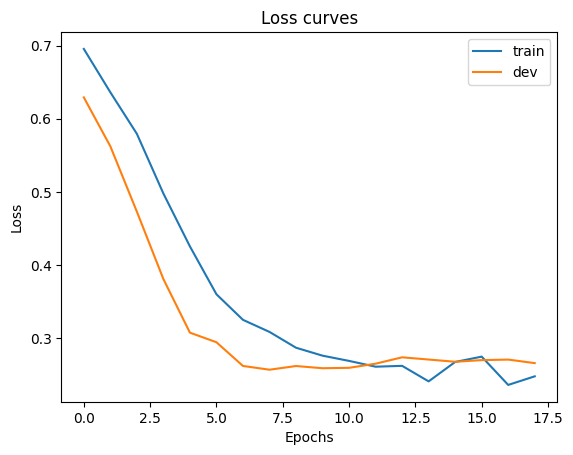

In [68]:
train_loss = history.history["loss"]
dev_loss = history.history["val_loss"]
acc_values = history.history["acc"]

plt.plot(train_loss, label="train")
plt.plot(dev_loss, label="dev")
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.76      0.95      0.85        41
         1.0       0.97      0.85      0.91        80

    accuracy                           0.88       121
   macro avg       0.87      0.90      0.88       121
weighted avg       0.90      0.88      0.89       121



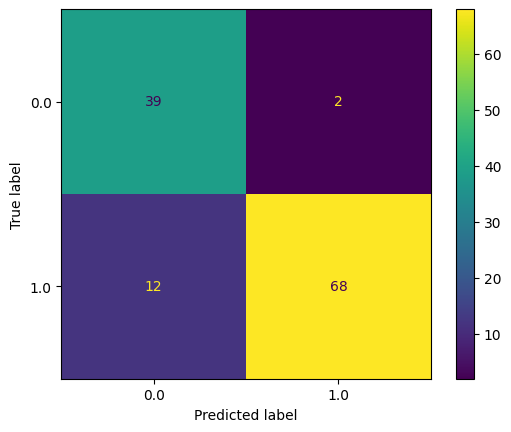

In [69]:
y_pred = model_kbest.predict(X_test_kbest)
predictions = (y_pred > 0.5).astype(int)

print(classification_report(y_test_kbest, predictions))
ConfusionMatrixDisplay.from_predictions(y_test_kbest, predictions);

###1.3 Error analysis


Let's plot the value of importance the model had given to the features.

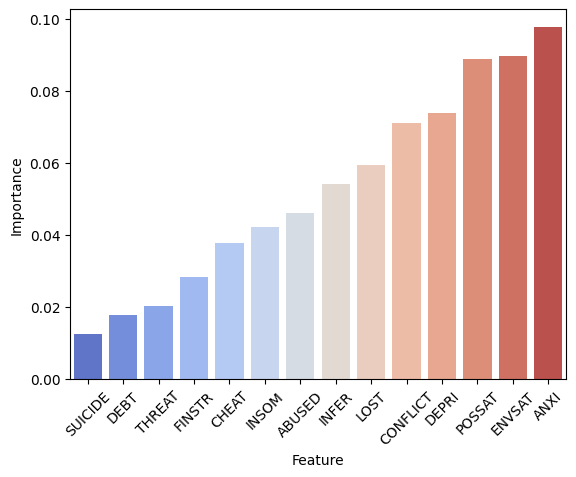

In [70]:
#get feature importance using shap
explainer = shap.Explainer(model_kbest, X_train_kbest_res)

shap_values = explainer.shap_values(X_test_kbest)

feat_import = np.abs(shap_values).mean(axis=0)

#create a data frame with shap calculations
import_feat = pd.DataFrame(index=X_kbest.columns,
                           data=feat_import,
                           columns=["Importance"])
import_feat = import_feat.sort_values("Importance")

#create the plot
colours = sns.color_palette("coolwarm",
                            len(import_feat))

sns.barplot(data=import_feat,
            x=import_feat.index,
            y="Importance",
            hue=import_feat.index,
            palette=colours,
            legend=False)

plt.xlabel("Feature")
plt.xticks(rotation=45);

Academic or professional position satisfaction (POSSAT) had the most impact on the predictions. Struggling with anxiety (ANXI) and feeling deprived (DEPRI) of something, or having lost someone (LOST) were also impactful features.

We'll separate the errors the model made from the correct predictions it performed.

In [20]:
def from_categorical(y_pred):
  return np.argmax(y_pred, axis=-1)

In [71]:
predictions = from_categorical(predictions)
error_class = np.where(predictions != y_test_kbest)[0]
feature_names = X_kbest.columns

x_error = X_test_kbest[error_class]

x_correct = X_test_kbest[predictions == y_test_kbest]

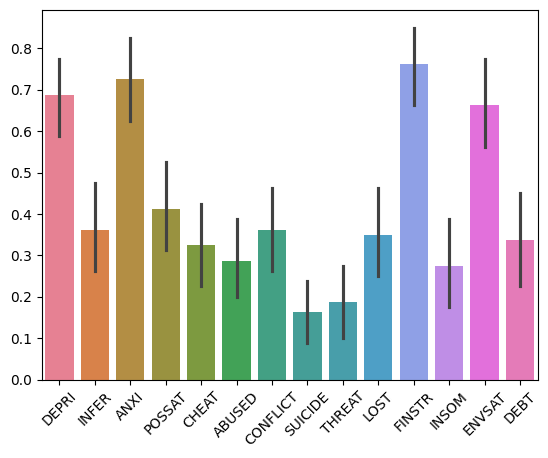

In [72]:
sns.barplot(data=x_error)
plt.xticks(rotation=45,
           ticks=np.arange(len(X_kbest.columns)),
           labels=X_kbest.columns);

The plot shows that DEPRI, ANXI, FINSTR and ENVSAT had the most weight in making incorrect predictions.

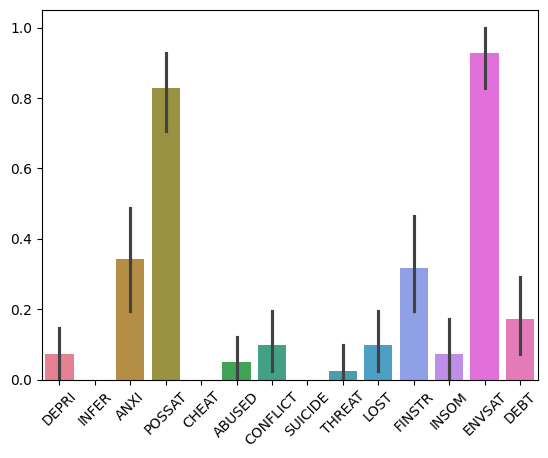

In [73]:
sns.barplot(data=x_correct)
plt.xticks(rotation=45,
           ticks=np.arange(len(X_kbest.columns)),
           labels=X_kbest.columns);

POSSAT and ENVSAT had the most weight in making correct predictions.

##2 RFE data set

###2.1 Data set balancing

In [38]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y_rfe, test_size=0.2,
                                                                    random_state=42, stratify=y_rfe)

X_train_rfe.shape, X_test_rfe.shape, y_train_rfe.shape, y_test_rfe.shape

((483, 14), (121, 14), (483,), (121,))

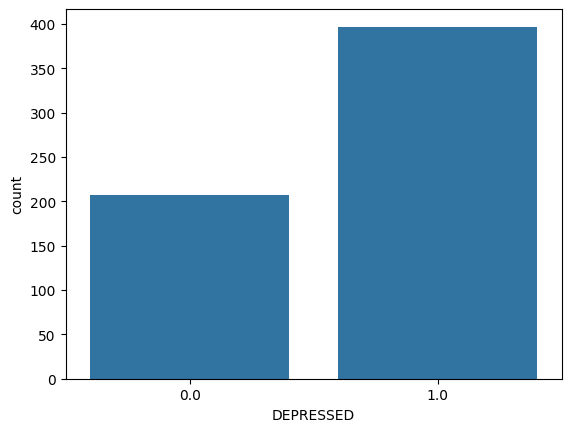

In [39]:
sns.countplot(x="DEPRESSED", data=depress_rfe);

In [40]:
X_train_rfe_res, y_train_rfe_res = sm.fit_resample(X_train_rfe, y_train_rfe)

In [41]:
np.bincount(y_train_rfe_res)

array([317, 317])

In [42]:
X_train_rfe_res.shape, y_train_rfe_res.shape

((634, 14), (634,))

###2.2 Training

In [43]:
scaler = MinMaxScaler()

X_train_rfe_res = scaler.fit_transform(X_train_rfe_res)
X_test_rfe = scaler.transform(X_test_rfe)

In [44]:
y_train_rfe_res = y_train_rfe_res.to_numpy()
y_test_rfe = y_test_rfe.to_numpy()

In [64]:
keras.backend.clear_session()

model_rfe = keras.models.Sequential()

early_stopping = EarlyStopping(monitor="val_loss", mode = "min", patience=10)
num_epochs = 200


model_rfe.add(keras.layers.Dense(100, activation='relu', name='hidden1'))
model_rfe.add(keras.layers.Dropout(0.5))
model_rfe.add(keras.layers.Dense(25, activation='relu', name='hidden2'))
model_rfe.add(keras.layers.Dropout(0.5))
model_rfe.add(keras.layers.Dense(1, activation='sigmoid', name='affine'))

model_rfe.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=keras.optimizers.Adam(learning_rate=0.001),
               metrics=["acc"])

history = model_rfe.fit(x=X_train_rfe_res,
                     y=y_train_rfe_res,
                     epochs=num_epochs,
                     validation_data=(X_test_rfe, y_test_rfe),
                     callbacks=[early_stopping])

model_rfe.summary()

Epoch 1/200
20/20 [==============================] - 3s 28ms/step - loss: 0.6658 - acc: 0.5773 - val_loss: 0.5999 - val_acc: 0.8512
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 0.6068 - acc: 0.7066 - val_loss: 0.5148 - val_acc: 0.8843
Epoch 3/200
20/20 [==============================] - 0s 3ms/step - loss: 0.5407 - acc: 0.7650 - val_loss: 0.4131 - val_acc: 0.8926
Epoch 4/200
20/20 [==============================] - 0s 3ms/step - loss: 0.4681 - acc: 0.8013 - val_loss: 0.3523 - val_acc: 0.8843
Epoch 5/200
20/20 [==============================] - 0s 4ms/step - loss: 0.4171 - acc: 0.8186 - val_loss: 0.3008 - val_acc: 0.8843
Epoch 6/200
20/20 [==============================] - 0s 3ms/step - loss: 0.3689 - acc: 0.8470 - val_loss: 0.2869 - val_acc: 0.8843
Epoch 7/200
20/20 [==============================] - 0s 4ms/step - loss: 0.3386 - acc: 0.8596 - val_loss: 0.2510 - val_acc: 0.9008
Epoch 8/200
20/20 [==============================] - 0s 3ms/step - loss: 0.3645 - 

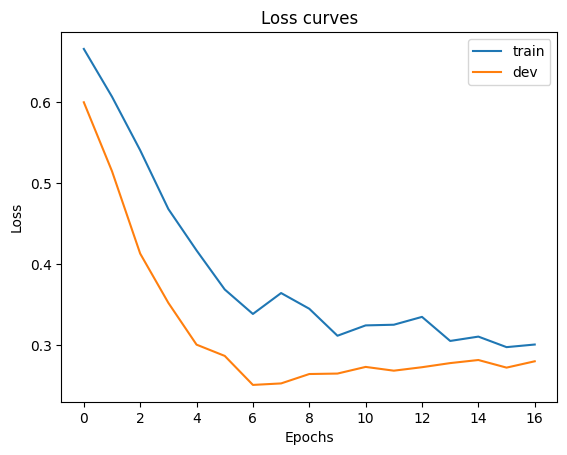

In [65]:
train_loss = history.history["loss"]
dev_loss = history.history["val_loss"]
acc_values = history.history["acc"]

plt.plot(train_loss, label="train")
plt.plot(dev_loss, label="dev")
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84        41
         1.0       0.97      0.84      0.90        80

    accuracy                           0.88       121
   macro avg       0.86      0.89      0.87       121
weighted avg       0.90      0.88      0.88       121



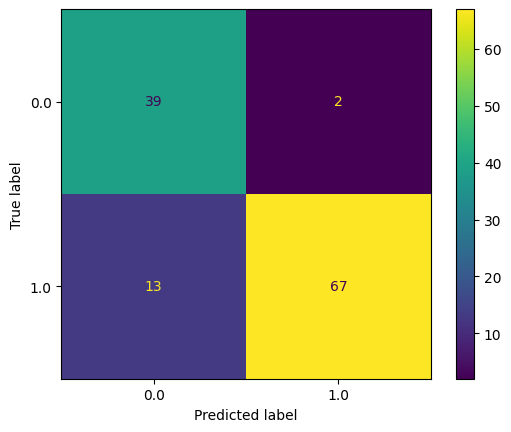

In [66]:
y_pred = model_rfe.predict(X_test_rfe)
predictions = (y_pred > 0.5).astype(int)

print(classification_report(y_test_rfe, predictions))
ConfusionMatrixDisplay.from_predictions(y_test_rfe, predictions);

###2.3 Error analysis

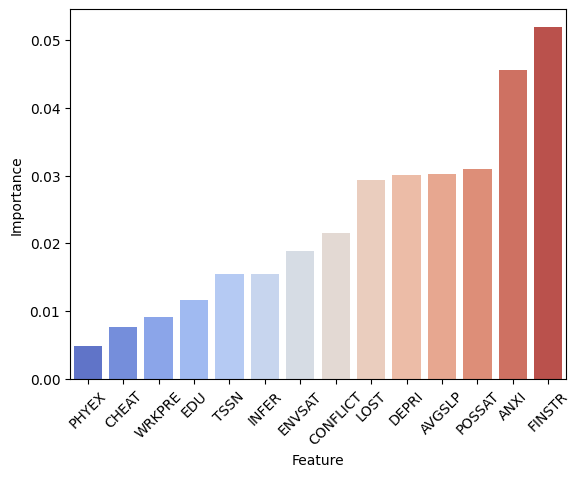

In [74]:
#get feature importance using shap
explainer = shap.Explainer(model_kbest, X_train_rfe_res)

shap_values = explainer.shap_values(X_test_rfe)

feat_import = np.abs(shap_values).mean(axis=0)

#create a data frame with shap calculations
import_feat = pd.DataFrame(index=X_rfe.columns,
                           data=feat_import,
                           columns=["Importance"])
import_feat = import_feat.sort_values("Importance")

#create the plot
colours = sns.color_palette("coolwarm",
                            len(import_feat))

sns.barplot(data=import_feat,
            x=import_feat.index,
            y="Importance",
            hue=import_feat.index,
            palette=colours,
            legend=False)

plt.xlabel("Feature")
plt.xticks(rotation=45);

In [75]:
predictions = from_categorical(predictions)
error_class = np.where(predictions != y_test_rfe)[0]
feature_names = X_rfe.columns

x_error = X_test_rfe[error_class]

x_correct = X_test_rfe[predictions == y_test_rfe]

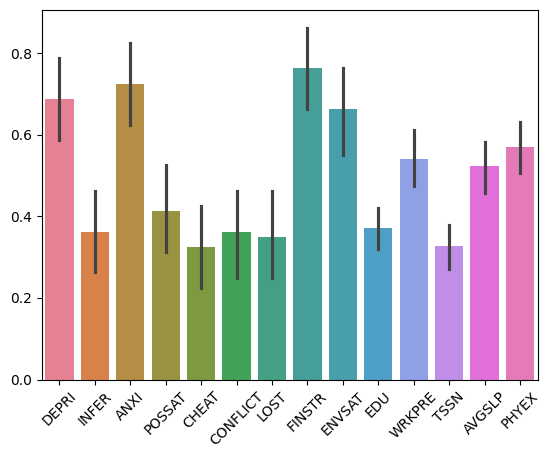

In [76]:
sns.barplot(data=x_error)
plt.xticks(rotation=45,
           ticks=np.arange(len(X_rfe.columns)),
           labels=X_rfe.columns);

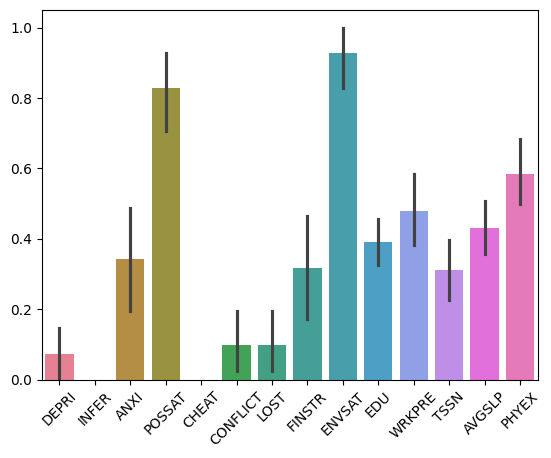

In [77]:
sns.barplot(data=x_correct)
plt.xticks(rotation=45,
           ticks=np.arange(len(X_rfe.columns)),
           labels=X_rfe.columns);

Contrary to the classical classifiers, the weight of the ordinal features in decision making is not as apparent. However, due to the complexity of neural models, it's not as straightforward to extract reliable or highly interpretable feature importance analysis as it is with decision based algorithms. Although thse neural models performed slightly better than the tree-based models, I trust the latter's error analysis a bit more.